# Method 6 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

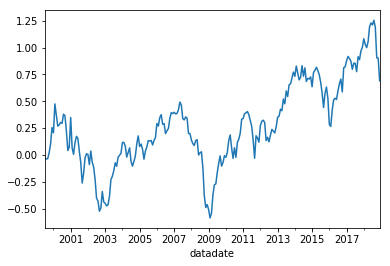

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.255972
2000-12-31   -0.144289
2001-12-31   -0.058612
2002-12-31   -0.443641
2003-12-31    0.805451
2004-12-31    0.158980
2005-12-31   -0.013315
2006-12-31    0.192466
2007-12-31   -0.133864
2008-12-31   -0.551131
2009-12-31    0.843829
2010-12-31    0.342903
2011-12-31   -0.160776
2012-12-31    0.125827
2013-12-31    0.405731
2014-12-31   -0.025583
2015-12-31   -0.116030
2016-12-31    0.192275
2017-12-31    0.100795
2018-12-31   -0.155951
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     460.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.96e-108
Time:                        14:14:13   Log-Likelihood:                 499.90
No. Observations:                 234   AIC:                            -989.8
Df Residuals:                     229   BIC:                            -972.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.923      0.357      -0.002       0.006
mktrf          1.2326      0.054     22.882      0.000       1.126       1.339
me             0.5541      0.063      8.842      0.000       0.431       0.678
ia             0.2122      0.095      2.228      0.027       0.025       0.400
roe           -0.9395      0.082    -11.524      0.000      -1.100      -0.779
==============================================================================
Omnibus:                       44.135   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.327
Skew:                           0.615   Prob(JB):                     5.79e-46
Kurtosis:                       7.456   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     217.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.43e-77
Time:                        14:14:13   Log-Likelihood:                 499.90
No. Observations:                 234   AIC:                            -989.8
Df Residuals:                     229   BIC:                            -972.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.980      0.327      -0.002       0.005
mktrf          1.2326      0.059     20.725      0.000       1.116       1.349
me             0.5541      0.088      6.293      0.000       0.381       0.727
ia             0.2122      0.160      1.324      0.185      -0.102       0.526
roe           -0.9395      0.164     -5.742      0.000      -1.260      -0.619
==============================================================================
Omnibus:                       44.135   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.327
Skew:                           0.615   Prob(JB):                     5.79e-46
Kurtosis:                       7.456   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     241.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.67e-81
Time:                        14:14:13   Log-Likelihood:                 499.90
No. Observations:                 234   AIC:                            -989.8
Df Residuals:                     229   BIC:                            -972.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.946      0.344      -0.002       0.006
mktrf          1.2326      0.057     21.500      0.000       1.120       1.345
me             0.5541      0.100      5.557      0.000       0.359       0.749
ia             0.2122      0.145      1.467      0.142      -0.071       0.496
roe           -0.9395      0.175     -5.357      0.000      -1.283      -0.596
==============================================================================
Omnibus:                       44.135   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.327
Skew:                           0.615   Prob(JB):                     5.79e-46
Kurtosis:                       7.456   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     277.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.11e-95
Time:                        14:14:13   Log-Likelihood:                 471.18
No. Observations:                 234   AIC:                            -930.4
Df Residuals:                     228   BIC:                            -909.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.290      0.772      -0.004       0.005
mktrf          1.3352      0.061     21.831      0.000       1.215       1.456
smb            0.6222      0.081      7.711      0.000       0.463       0.781
hml            0.3376      0.095      3.548      0.000       0.150       0.525
rmw           -0.7458      0.108     -6.932      0.000      -0.958      -0.534
cma           -0.0121      0.137     -0.089      0.929      -0.282       0.257
==============================================================================
Omnibus:                      114.003   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.324
Skew:                           1.777   Prob(JB):                    3.64e-175
Kurtosis:                      11.352   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     150.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.76e-70
Time:                        14:14:13   Log-Likelihood:                 471.18
No. Observations:                 234   AIC:                            -930.4
Df Residuals:                     228   BIC:                            -909.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.315      0.753      -0.003       0.005
mktrf          1.3352      0.063     21.142      0.000       1.211       1.459
smb            0.6222      0.113      5.523      0.000       0.401       0.843
hml            0.3376      0.149      2.271      0.023       0.046       0.629
rmw           -0.7458      0.164     -4.551      0.000      -1.067      -0.425
cma           -0.0121      0.270     -0.045      0.964      -0.542       0.517
==============================================================================
Omnibus:                      114.003   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.324
Skew:                           1.777   Prob(JB):                    3.64e-175
Kurtosis:                      11.352   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     211.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-83
Time:                        14:14:13   Log-Likelihood:                 471.18
No. Observations:                 234   AIC:                            -930.4
Df Residuals:                     228   BIC:                            -909.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.281      0.779      -0.004       0.005
mktrf          1.3352      0.061     21.760      0.000       1.215       1.455
smb            0.6222      0.105      5.907      0.000       0.416       0.829
hml            0.3376      0.148      2.283      0.022       0.048       0.627
rmw           -0.7458      0.183     -4.077      0.000      -1.104      -0.387
cma           -0.0121      0.285     -0.043      0.966      -0.570       0.546
==============================================================================
Omnibus:                      114.003   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.324
Skew:                           1.777   Prob(JB):                    3.64e-175
Kurtosis:                      11.352   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     451.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.36e-107
Time:                        14:14:13   Log-Likelihood:                 497.78
No. Observations:                 234   AIC:                            -985.6
Df Residuals:                     229   BIC:                            -968.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.206      0.837      -0.004       0.003
mktrf          1.3067      0.050     26.107      0.000       1.208       1.405
smb            0.9914      0.062     15.868      0.000       0.868       1.114
hml            0.1376      0.062      2.217      0.028       0.015       0.260
umd           -0.4568      0.041    -11.219      0.000      -0.537      -0.377
==============================================================================
Omnibus:                       29.017   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.787
Skew:                           0.560   Prob(JB):                     7.02e-16
Kurtosis:                       5.430   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     246.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-81
Time:                        14:14:13   Log-Likelihood:                 497.78
No. Observations:                 234   AIC:                            -985.6
Df Residuals:                     229   BIC:                            -968.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.224      0.823      -0.004       0.003
mktrf          1.3067      0.059     22.204      0.000       1.191       1.422
smb            0.9914      0.071     14.032      0.000       0.853       1.130
hml            0.1376      0.072      1.898      0.058      -0.005       0.280
umd           -0.4568      0.074     -6.149      0.000      -0.602      -0.311
==============================================================================
Omnibus:                       29.017   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.787
Skew:                           0.560   Prob(JB):                     7.02e-16
Kurtosis:                       5.430   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     192.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.43e-72
Time:                        14:14:13   Log-Likelihood:                 497.78
No. Observations:                 234   AIC:                            -985.6
Df Residuals:                     229   BIC:                            -968.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.219      0.827      -0.004       0.003
mktrf          1.3067      0.056     23.534      0.000       1.198       1.416
smb            0.9914      0.065     15.231      0.000       0.864       1.119
hml            0.1376      0.070      1.968      0.049       0.001       0.275
umd           -0.4568      0.067     -6.862      0.000      -0.587      -0.326
==============================================================================
Omnibus:                       29.017   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.787
Skew:                           0.560   Prob(JB):                     7.02e-16
Kurtosis:                       5.430   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     210.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.18e-52
Time:                        14:14:13   Log-Likelihood:                 230.70
No. Observations:                 120   AIC:                            -451.4
Df Residuals:                     115   BIC:                            -437.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.724      0.087      -0.001       0.013
mktrf          1.2270      0.093     13.170      0.000       1.042       1.412
me             0.4632      0.092      5.033      0.000       0.281       0.645
ia             0.3118      0.144      2.164      0.033       0.026       0.597
roe           -1.0468      0.128     -8.208      0.000      -1.299      -0.794
==============================================================================
Omnibus:                        9.863   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.420
Skew:                           0.211   Prob(JB):                     3.68e-05
Kurtosis:                       4.976   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     165.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-46
Time:                        14:14:13   Log-Likelihood:                 230.70
No. Observations:                 120   AIC:                            -451.4
Df Residuals:                     115   BIC:                            -437.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.976      0.048    4.76e-05       0.012
mktrf          1.2270      0.084     14.643      0.000       1.063       1.391
me             0.4632      0.101      4.585      0.000       0.265       0.661
ia             0.3118      0.202      1.541      0.123      -0.085       0.708
roe           -1.0468      0.193     -5.412      0.000      -1.426      -0.668
==============================================================================
Omnibus:                        9.863   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.420
Skew:                           0.211   Prob(JB):                     3.68e-05
Kurtosis:                       4.976   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     218.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.82e-53
Time:                        14:14:13   Log-Likelihood:                 230.70
No. Observations:                 120   AIC:                            -451.4
Df Residuals:                     115   BIC:                            -437.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.979      0.048    5.76e-05       0.012
mktrf          1.2270      0.084     14.582      0.000       1.062       1.392
me             0.4632      0.116      3.978      0.000       0.235       0.691
ia             0.3118      0.179      1.743      0.081      -0.039       0.662
roe           -1.0468      0.204     -5.127      0.000      -1.447      -0.647
==============================================================================
Omnibus:                        9.863   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.420
Skew:                           0.211   Prob(JB):                     3.68e-05
Kurtosis:                       4.976   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     122.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-44
Time:                        14:14:13   Log-Likelihood:                 214.49
No. Observations:                 120   AIC:                            -417.0
Df Residuals:                     114   BIC:                            -400.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.455      0.148      -0.002       0.014
mktrf          1.4234      0.113     12.602      0.000       1.200       1.647
smb            0.5488      0.128      4.290      0.000       0.295       0.802
hml            0.3641      0.157      2.323      0.022       0.054       0.675
rmw           -0.7912      0.185     -4.280      0.000      -1.157      -0.425
cma            0.0744      0.203      0.367      0.714      -0.327       0.476
==============================================================================
Omnibus:                       45.593   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.548
Skew:                           1.386   Prob(JB):                     2.23e-30
Kurtosis:                       7.430   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     74.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-34
Time:                        14:14:14   Log-Likelihood:                 214.49
No. Observations:                 120   AIC:                            -417.0
Df Residuals:                     114   BIC:                            -400.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.003      1.809      0.070      -0.000       0.012
mktrf          1.4234      0.118     12.026      0.000       1.191       1.655
smb            0.5488      0.152      3.609      0.000       0.251       0.847
hml            0.3641      0.226      1.611      0.107      -0.079       0.807
rmw           -0.7912      0.221     -3.582      0.000      -1.224      -0.358
cma            0.0744      0.327      0.228      0.820      -0.566       0.715
==============================================================================
Omnibus:                       45.593   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.548
Skew:                           1.386   Prob(JB):                     2.23e-30
Kurtosis:                       7.430   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     94.32
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.54e-39
Time:                        14:14:14   Log-Likelihood:                 214.49
No. Observations:                 120   AIC:                            -417.0
Df Residuals:                     114   BIC:                            -400.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.653      0.098      -0.001       0.013
mktrf          1.4234      0.118     12.052      0.000       1.192       1.655
smb            0.5488      0.140      3.913      0.000       0.274       0.824
hml            0.3641      0.225      1.616      0.106      -0.078       0.806
rmw           -0.7912      0.239     -3.309      0.001      -1.260      -0.323
cma            0.0744      0.343      0.217      0.828      -0.598       0.746
==============================================================================
Omnibus:                       45.593   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.548
Skew:                           1.386   Prob(JB):                     2.23e-30
Kurtosis:                       7.430   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     206.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-51
Time:                        14:14:14   Log-Likelihood:                 229.71
No. Observations:                 120   AIC:                            -449.4
Df Residuals:                     115   BIC:                            -435.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.003      0.921      0.359      -0.004       0.010
mktrf          1.3731      0.083     16.591      0.000       1.209       1.537
smb            1.0033      0.094     10.648      0.000       0.817       1.190
hml            0.1570      0.094      1.663      0.099      -0.030       0.344
umd           -0.4623      0.058     -7.945      0.000      -0.578      -0.347
==============================================================================
Omnibus:                        5.166   Durbin-Watson:                   2.543
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                5.622
Skew:                           0.270   Prob(JB):                       0.0601
Kurtosis:                       3.913   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     111.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.40e-38
Time:                        14:14:14   Log-Likelihood:                 229.71
No. Observations:                 120   AIC:                            -449.4
Df Residuals:                     115   BIC:                            -435.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.003      1.131      0.258      -0.002       0.009
mktrf          1.3731      0.093     14.766      0.000       1.191       1.555
smb            1.0033      0.103      9.694      0.000       0.800       1.206
hml            0.1570      0.111      1.408      0.159      -0.062       0.376
umd           -0.4623      0.088     -5.242      0.000      -0.635      -0.289
==============================================================================
Omnibus:                        5.166   Durbin-Watson:                   2.543
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                5.622
Skew:                           0.270   Prob(JB):                       0.0601
Kurtosis:                       3.913   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     94.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.22e-35
Time:                        14:14:14   Log-Likelihood:                 229.71
No. Observations:                 120   AIC:                            -449.4
Df Residuals:                     115   BIC:                            -435.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.003      1.144      0.253      -0.002       0.009
mktrf          1.3731      0.087     15.744      0.000       1.202       1.544
smb            1.0033      0.096     10.477      0.000       0.816       1.191
hml            0.1570      0.115      1.371      0.170      -0.067       0.381
umd           -0.4623      0.076     -6.116      0.000      -0.610      -0.314
==============================================================================
Omnibus:                        5.166   Durbin-Watson:                   2.543
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                5.622
Skew:                           0.270   Prob(JB):                       0.0601
Kurtosis:                       3.913   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     381.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.31e-63
Time:                        14:14:14   Log-Likelihood:                 304.90
No. Observations:                 114   AIC:                            -599.8
Df Residuals:                     109   BIC:                            -586.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -1.150      0.253      -0.005       0.001
mktrf          1.2132      0.050     24.189      0.000       1.114       1.313
me             0.7722      0.077      9.972      0.000       0.619       0.926
ia             0.0032      0.107      0.030      0.976      -0.210       0.216
roe           -0.7144      0.094     -7.570      0.000      -0.901      -0.527
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.144
Skew:                           0.403   Prob(JB):                       0.0764
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     360.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.87e-62
Time:                        14:14:14   Log-Likelihood:                 304.90
No. Observations:                 114   AIC:                            -599.8
Df Residuals:                     109   BIC:                            -586.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.592      0.111      -0.004       0.000
mktrf          1.2132      0.063     19.201      0.000       1.089       1.337
me             0.7722      0.089      8.670      0.000       0.598       0.947
ia             0.0032      0.154      0.021      0.983      -0.299       0.306
roe           -0.7144      0.094     -7.612      0.000      -0.898      -0.530
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.144
Skew:                           0.403   Prob(JB):                       0.0764
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     330.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.76e-60
Time:                        14:14:14   Log-Likelihood:                 304.90
No. Observations:                 114   AIC:                            -599.8
Df Residuals:                     109   BIC:                            -586.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.616      0.106      -0.004       0.000
mktrf          1.2132      0.065     18.633      0.000       1.086       1.341
me             0.7722      0.099      7.763      0.000       0.577       0.967
ia             0.0032      0.183      0.018      0.986      -0.354       0.361
roe           -0.7144      0.101     -7.057      0.000      -0.913      -0.516
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.144
Skew:                           0.403   Prob(JB):                       0.0764
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     262.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.54e-59
Time:                        14:14:14   Log-Likelihood:                 297.53
No. Observations:                 114   AIC:                            -583.1
Df Residuals:                     108   BIC:                            -566.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -1.942      0.055      -0.007    7.39e-05
mktrf          1.2450      0.051     24.286      0.000       1.143       1.347
smb            0.7506      0.083      9.019      0.000       0.586       0.916
hml            0.2595      0.106      2.445      0.016       0.049       0.470
rmw           -0.6607      0.130     -5.084      0.000      -0.918      -0.403
cma           -0.1177      0.165     -0.713      0.477      -0.445       0.209
==============================================================================
Omnibus:                        0.264   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.218
Skew:                           0.104   Prob(JB):                        0.897
Kurtosis:                       2.950   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     172.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.80e-50
Time:                        14:14:14   Log-Likelihood:                 297.53
No. Observations:                 114   AIC:                            -583.1
Df Residuals:                     108   BIC:                            -566.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.225      0.026      -0.007      -0.000
mktrf          1.2450      0.054     22.914      0.000       1.139       1.351
smb            0.7506      0.071     10.506      0.000       0.611       0.891
hml            0.2595      0.100      2.608      0.009       0.064       0.455
rmw           -0.6607      0.108     -6.133      0.000      -0.872      -0.450
cma           -0.1177      0.205     -0.574      0.566      -0.519       0.284
==============================================================================
Omnibus:                        0.264   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.218
Skew:                           0.104   Prob(JB):                        0.897
Kurtosis:                       2.950   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     173.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.78e-50
Time:                        14:14:14   Log-Likelihood:                 297.53
No. Observations:                 114   AIC:                            -583.1
Df Residuals:                     108   BIC:                            -566.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.135      0.033      -0.007      -0.000
mktrf          1.2450      0.056     22.345      0.000       1.136       1.354
smb            0.7506      0.078      9.647      0.000       0.598       0.903
hml            0.2595      0.094      2.776      0.006       0.076       0.443
rmw           -0.6607      0.083     -7.961      0.000      -0.823      -0.498
cma           -0.1177      0.242     -0.487      0.626      -0.591       0.356
==============================================================================
Omnibus:                        0.264   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.218
Skew:                           0.104   Prob(JB):                        0.897
Kurtosis:                       2.950   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     342.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-60
Time:                        14:14:14   Log-Likelihood:                 299.15
No. Observations:                 114   AIC:                            -588.3
Df Residuals:                     109   BIC:                            -574.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.002     -2.084      0.040      -0.007      -0.000
mktrf          1.2519      0.050     25.046      0.000       1.153       1.351
smb            0.9221      0.078     11.831      0.000       0.768       1.077
hml            0.1856      0.080      2.312      0.023       0.027       0.345
umd           -0.3502      0.061     -5.784      0.000      -0.470      -0.230
==============================================================================
Omnibus:                        2.989   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.490
Skew:                          -0.235   Prob(JB):                        0.288
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     290.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.88e-57
Time:                        14:14:14   Log-Likelihood:                 299.15
No. Observations:                 114   AIC:                            -588.3
Df Residuals:                     109   BIC:                            -574.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.001     -2.794      0.005      -0.006      -0.001
mktrf          1.2519      0.054     23.110      0.000       1.146       1.358
smb            0.9221      0.066     13.880      0.000       0.792       1.052
hml            0.1856      0.094      1.976      0.048       0.002       0.370
umd           -0.3502      0.066     -5.298      0.000      -0.480      -0.221
==============================================================================
Omnibus:                        2.989   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.490
Skew:                          -0.235   Prob(JB):                        0.288
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     313.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.55e-59
Time:                        14:14:14   Log-Likelihood:                 299.15
No. Observations:                 114   AIC:                            -588.3
Df Residuals:                     109   BIC:                            -574.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.001     -2.828      0.005      -0.006      -0.001
mktrf          1.2519      0.053     23.806      0.000       1.149       1.355
smb            0.9221      0.061     15.181      0.000       0.803       1.041
hml            0.1856      0.084      2.210      0.027       0.021       0.350
umd           -0.3502      0.068     -5.127      0.000      -0.484      -0.216
==============================================================================
Omnibus:                        2.989   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.490
Skew:                          -0.235   Prob(JB):                        0.288
Kurtosis:                       3.550   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""